# __R-Group exploratory analysis__

We will use R-Group decomposition for the analysis

## Requiremenst for the notebook
!pip install useful_rdkit_utils mols2grid


In [97]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from rdkit.Chem import rdRGroupDecomposition
import pandas as pd
import mols2grid
import useful_rdkit_utils as uru
from ipywidgets import interact


## __Steps for R-group exploratory analysis__
```python
1. Read the input data from a SMILES file

2. Cluster the input data to identify similar molecules

3. View the largest cluster and identify the common scaffold

4. Perform the R-group decomposition

5. View the R-groups and their frequency
```


In [98]:
# Read in data
df = pd.read_csv("HDAC1_ChEMBL_prepared_data/HDAC1_ChEMBL_IC50.csv")
df.head()

,Unnamed: 0,molecule_chembl_id,IC50,units,SMILES,pIC50,activity_label,ML_activity_label
0,0,CHEMBL3621294,0.00687,nM,O=C(CCCCCCC(=O)Nc1ccc2c(c1)/C(=C/c1ccc[nH]1)C(...,11.163043,active,1
1,1,CHEMBL3689858,0.01000,nM,CCC(CC)CN(CC)Cc1c(C)nc2cc(/C=C/C(=O)NO)ccn12,11.000000,active,1
2,2,CHEMBL3689829,0.02000,nM,CCCCNCc1c(CCCC)nc2cc(/C=C/C(=O)NO)ccn12,10.698970,active,1
3,3,CHEMBL4861467,0.05000,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,10.301030,active,1
4,4,CHEMBL3689834,0.06000,nM,CCCCc1nc2cc(/C=C/C(=O)NO)ccn2c1CN(CC)CCCC,10.221849,active,1


In [99]:
# Add Rdkit molecules from the smiles
df["rd_mol"] = df["SMILES"].apply(Chem.MolFromSmiles)

# Add morgan fingerprints usng the rdmol
df["fp"] = df["rd_mol"].apply(uru.mol2morgan_fp)

# Cluster the molecules using Butina clustering
df["cluster"] = uru.taylor_butina_clustering(df["fp"])

# Inspecting the sizes of the cluster
print(df["cluster"].value_counts())

# Visualize the molecules in the second largest cluster. Can use others
mols2grid.display(df.query("cluster == 0"),
                  mol_col="rd_mol",
                  subset=["molecule_chembl_id", "img", "IC50"],)

cluster
0       67
1       60
2       48
4       45
3       45
        ..
497      1
582      1
1412     1
1411     1
516      1
Name: count, Length: 1639, dtype: int64


MolGridWidget()

### Use the previous noteboook to find the common scaffold of the clusters

It will show that the scaffold. Using the scaffold one can use a sketcher tosketch the R-groups and save the core scaffold with R-groups in a mol-file,

In [100]:
scaf_mb = """
  MJ240100                      

 13 14  0  0  0  0  0  0  0  0999 V2000
   -5.8262    3.7044    0.0000 R#  0  0  0  0  0  0  0  0  0  0  0  0
   -3.6828    3.2920    0.0000 N   0  0  0  0  0  0  0  0  0  0  0  0
   -3.6828    2.4669    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.3973    2.0544    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.1117    2.4669    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -5.1117    3.2920    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.3973    3.7045    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.3973    1.2293    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -3.6830    0.8167    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9684    1.2292    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -2.9684    2.0543    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
   -4.3973    4.5295    0.0000 O   0  0  0  0  0  0  0  0  0  0  0  0
   -5.1118    4.9419    0.0000 C   0  0  0  0  0  0  0  0  0  0  0  0
  6  1  1  0  0  0  0
  4  3  1  0  0  0  0
  5  4  2  0  0  0  0
  6  5  1  0  0  0  0
  7  6  2  0  0  0  0
  8  9  2  0  0  0  0
  9 10  1  0  0  0  0
  4  8  1  0  0  0  0
  7 12  1  0  0  0  0
 12 13  1  0  0  0  0
 10 11  2  0  0  0  0
 11  3  1  0  0  0  0
  2  7  1  0  0  0  0
  3  2  2  0  0  0  0
M  RGP  1   1   1
M  END
"""

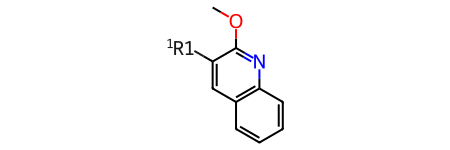

In [101]:
# Convert the molfile to rdkit molecule
core = Chem.MolFromMolBlock(scaf_mb)
core

In [102]:
# Create a pandas df from cluster 0
df_0 = df.query("cluster == 0").copy()

# Add index column to df_0
df_0["index"] = range(0,len(df_0))


## __Perform the R-group Decomposition__

**Pat Walters explaination for R-group decomp.**

We're using the function rdRGroupDecomposition.RGroupDecompose from the RDKit. Note that RDKit returns two values from this function.

1. rgd - a dictionary containing the results of the R-group decomposition. This dictionary has keys containing the core with a key "Core", and the R-groups in keys named "R1", "R2", etc. Each dictionary key links to a list of cores or R-groups corresponding input molecules that matched the core (didn't fail).

2. failed - a list containing the indices of molecules that did not match the core.

In [103]:
rgd,failed = rdRGroupDecomposition.RGroupDecompose([core], df_0["rd_mol"].values,asRows=False)

[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches
[12:03:05] No core matches


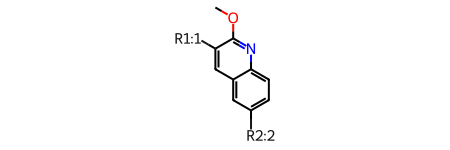

In [109]:
rgd["Core"][1]

In [105]:
failed

[0,
 4,
 7,
 9,
 10,
 11,
 12,
 13,
 14,
 17,
 18,
 19,
 20,
 23,
 30,
 36,
 39,
 41,
 42,
 48,
 50,
 52,
 53,
 54,
 57,
 60,
 64]

In [106]:
# Looking at the molecules that failed to understand why they are not R-groups
mols2grid.display(df_0.iloc[failed], 
                  mol_col="rd_mol", 
                  subset=["img","index"])

# One can see that the R-groups do not take C as a potential R-Group. Therefore scaffols with similar structures are not always shown

MolGridWidget()

In [107]:
# Deleting the strcutures that failed
# First reset the index
df_0.reset_index(inplace=True)

# frop the failed molecules
df_0 = df_0.drop(failed, axis=0)

In [111]:
# Obtaing the names of the R-grouops and saving the R-groups smiles to df_0

# Get names of R-groups
r_groups = [x for x in rgd.keys() if x != "Core"]

#Add smiles to df_0
for r in sorted(r_groups):
    df_0[r] = rgd[r]
    df_0[r] = df_0[r].apply(Chem.MolToSmiles)
df_0.head(3)

,level_0,Unnamed: 0,molecule_chembl_id,IC50,units,SMILES,pIC50,activity_label,ML_activity_label,rd_mol,fp,cluster,index,R1,R2
1,6,6,CHEMBL4649205,0.085,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,10.070581,active,1,<rdkit.Chem.rdchem.Mol object at 0x2a982b990>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,1,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(CC1CC1)C...,[H][*:2]
2,8,8,CHEMBL4644038,0.110,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C(C)C)CC...,9.958607,active,1,<rdkit.Chem.rdchem.Mol object at 0x2a982b8b0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,2,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C(C)C)CC...,[H][*:2]
3,20,20,CHEMBL4642518,0.190,nM,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,9.721246,active,1,<rdkit.Chem.rdchem.Mol object at 0x2a982b370>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,3,CCC(=O)CCCCC[C@H](NC(=O)[C@H]1CC12CCN(C)CC2)c1...,[H][*:2]


In [112]:
# View freequency of the R-groups
@interact(rg=r_groups)
def display_rgroups(rg):
    vc_df = uru.value_counts_df(df_0,rg)
    return mols2grid.display(vc_df,smiles_col=rg,subset=["img","count"])

interactive(children=(Dropdown(description='rg', options=('R1', 'R2'), value='R1'), Output()), _dom_classes=('…